# Home Credit Default Risk Prediction

## 1. Setup shared libraries on path

In [4]:
#import lib.initShared  # custom library
import os

In [5]:
#Capture working directory
cwd = os.getcwd()

In [5]:
# Initialize environment to load custom libraries from shared path
#lib.initShared.initializeSharedLib(cwd)

## 2. Data Ingestion

### 2.1. Create Spark session

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('HomeCredit').getOrCreate()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### 2.2 Connect to remote cluster

In [5]:
from S3Serializer import S3Bucket

In [7]:
s3=S3Bucket()
s3.connect(host = "18.212.194.194", username = "centos", key = 'InternalPOC_Digital.pem')

Connecting to host  18.212.194.194
Connected


### 2.3 Fetch data from remote cluster

In [ ]:
s3.get_dir_remote(cwd+'/data/dataset/','home_credit\n')

### 2.4 Load data

In [6]:
data=spark.read.parquet(cwd+'/dataset_home_credit')

In [7]:
import spark_df_profiling

In [8]:
spark_df_profiling.ProfileReport(data)

Number of variables,122
Number of observations,307511
Total Missing (%),10.0%
Total size in memory,0.0 B
Average record size in memory,0.0 B
Numeric,72
Categorical,16
Date,0
Text (Unique),0
Rejected,34
Distinct count,307511


# 3. Data Cleansing

#### It performs follwing activities:<br>
<li>Removes the column containing highest number(30%) of null values</li>
<li>Imputes the remaining null containing columns with frequent occuring value of the respective columns</li>

In [13]:
from Data_Cleaning_Lib.CleanLib import DataCleaningLib

In [14]:
cln = DataCleaningLib()

In [15]:
data=cln.cleaning(data)

1.Data Cleaning and Preprocessing
processing--> SK_ID_CURR
processing--> TARGET
processing--> NAME_CONTRACT_TYPE
processing--> CODE_GENDER
processing--> FLAG_OWN_CAR
processing--> FLAG_OWN_REALTY
processing--> CNT_CHILDREN
processing--> AMT_INCOME_TOTAL
processing--> AMT_CREDIT
processing--> AMT_ANNUITY
processing--> AMT_GOODS_PRICE
processing--> NAME_TYPE_SUITE
processing--> NAME_INCOME_TYPE
processing--> NAME_EDUCATION_TYPE
processing--> NAME_FAMILY_STATUS
processing--> NAME_HOUSING_TYPE
processing--> REGION_POPULATION_RELATIVE
processing--> DAYS_BIRTH
processing--> DAYS_EMPLOYED
processing--> DAYS_REGISTRATION
processing--> DAYS_ID_PUBLISH
processing--> OWN_CAR_AGE
processing--> FLAG_MOBIL
processing--> FLAG_EMP_PHONE
processing--> FLAG_WORK_PHONE
processing--> FLAG_CONT_MOBILE
processing--> FLAG_PHONE
processing--> FLAG_EMAIL
processing--> OCCUPATION_TYPE
processing--> CNT_FAM_MEMBERS
processing--> REGION_RATING_CLIENT
processing--> REGION_RATING_CLIENT_W_CITY
processing--> WEEKDAY

In [17]:
data.write.csv(cwd+'data\cleaned_data.csv')

In [18]:
data_pandas=data.toPandas()
y=data_pandas['TARGET'].values
data_pandas.drop(['TARGET','SK_ID_CURR'],axis=1,inplace=True)
categorical_columns=set(data_pandas.columns)-set(data_pandas._get_numeric_data().columns)
numeric_columns=data_pandas._get_numeric_data().columns
X=data_pandas[list(numeric_columns)].values

## 3.1 Feature Importance
Feature selection algorithm like
<li>LightGBM</li> 
<li>CatBoostClassifier</li>
<li>RandomForestClassifier</li>
to select the best correlated features

In [19]:
from Feature_Importance_Lib.Feature_Importance import Feature_Importance_Transformer
fi = Feature_Importance_Transformer(data_pandas)

Plot Top 40 feature importances…


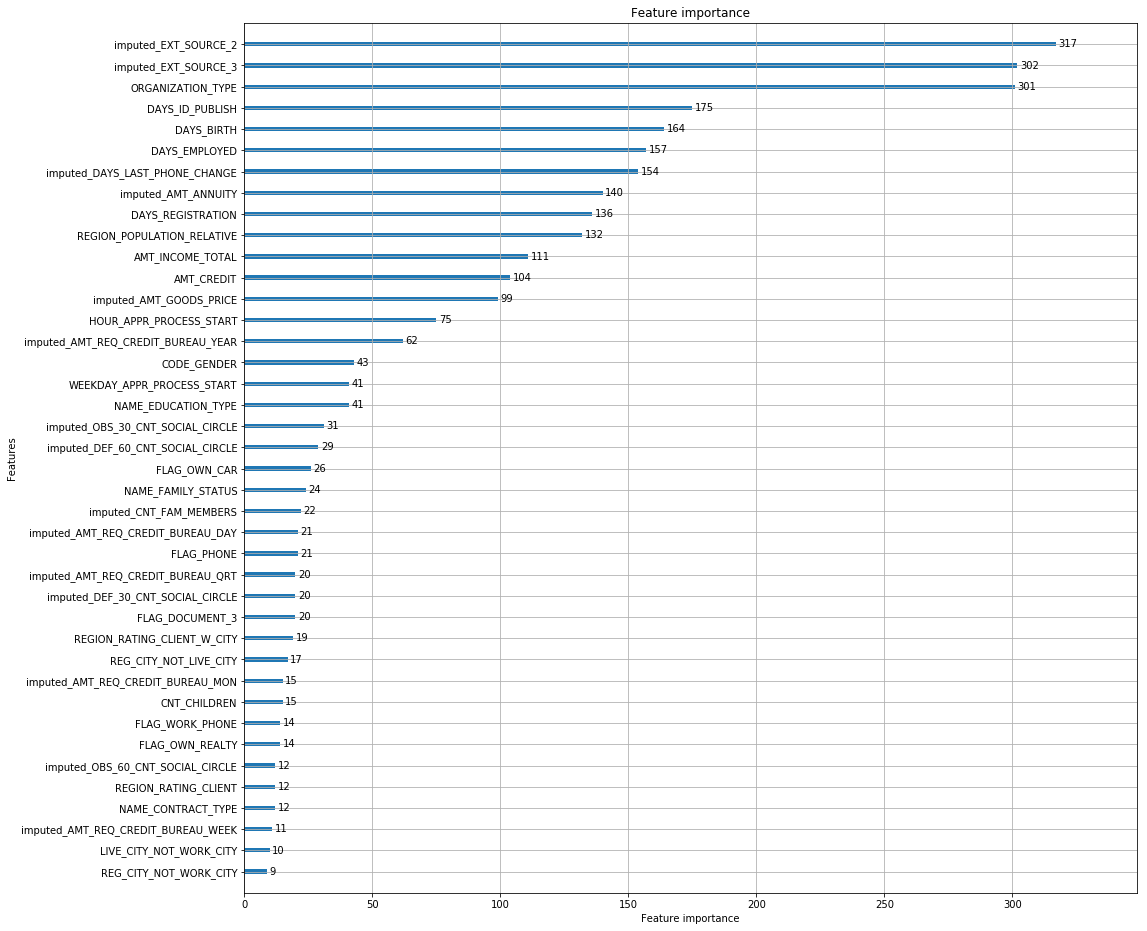

In [20]:
fi.feature_importance_lightGBM(y=y,categorical_columns=categorical_columns,n_features=40)

## 3.2 Label Encoding
<b>Encodes all the categorical columns in the dataframe and returns the string indexed dataframe</b>

In [28]:
from Encode_Lib import EncodeLib

In [21]:
pp = EncodeLib.LabelEncode(outputCols=['TARGET'])

In [22]:
data = pp.transform(data)

FLAG_OWN_REALTY
NAME_CONTRACT_TYPE
WEEKDAY_APPR_PROCESS_START
FLAG_OWN_CAR
ORGANIZATION_TYPE
CODE_GENDER
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_TYPE_SUITE
NAME_HOUSING_TYPE


## 3.3 One Hot Encoding
<b>One Hot Encoding(OHEncode) which encodes the string indexed columns in the dataframe and returns the encoded(vectors) dataframe</b>

In [24]:
ohe = EncodeLib.OHEncode()

In [25]:
data = ohe.transform(data)

## 3.4 Vector Encode
<b>converts all the independent variables into single column named 'features'(vector) which can be used for model building</b>

In [26]:
vec = EncodeLib.VectorChange(outputCols=['TARGET'])

In [27]:
data = vec.transform(data)

# 4. Model Building 

In [29]:
from Model_Fit_Lib import Model_Fit

### 4.1 Logistic regression

In [30]:
model1 = Model_Fit.ModelFit(inputCol='LR')

In [31]:
log_reg_pred = model1.transform(data)

In [32]:
model1._evaluate_prediction()

0.7384559798478479


### 4.2 Random Forest

In [33]:
model2 = Model_Fit.ModelFit(inputCol='RF')

In [34]:
rand_forest_pred = model2.transform(data)

In [35]:
model2._evaluate_prediction()

0.7091730705834485


# 5. Model saving

In [37]:
log_reg_pred.save(cwd+'/data/log_reg.pkl')

In [38]:
from pyspark.ml.classification import LogisticRegressionModel

In [39]:
mm = LogisticRegressionModel.load(cwd+'/data/log_reg.pkl')

In [40]:
predicted=mm.transform(data)

In [41]:
predicted.select('prediction').show()

+----------+
|prediction|
+----------+
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
+----------+
only showing top 20 rows



# 6. API Deployment

In [42]:
import apilib  # shared custom library

In [43]:
swaggerSpecFile = cwd+'/data/swagger_HomeCreditRisk.yaml'
appPort = 8000

In [44]:
# Swagger UI becomes available after running API on URL http://<serverUrl>:mappedPort/ui
# mappedPort is port mapped as per nginx configuration
# For port 8000, mappedPort is 9390, thus URL is http://34.198.60.96:9390/ui/

# Run API
apilib.api_run(swaggerSpecFile, appPort)

# To stop the API, interrupt the cell (using button provided) or shutdown notebook (using Notebook interface)

 * Running on http://0.0.0.0:8000/ (Press CTRL+C to quit)


In [9]:
import lightgbm as lgb

In [ ]:
lgb.train()